In [1]:
import os
import json
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import gc
from google.colab import drive

drive.mount('/content/drive')

base_dataset_path = '/content/drive/MyDrive/my_dataset'
vpn_folders = ['SSTP', 'OpenVPN', 'PPTP', 'L2TP', 'WireGuard', 'L2TP IPsec']
target_file_names = ['meet.json', 'mail.json', 'ssh.json', 'streaming.json','non_streaming.json']

data = []

for folder in vpn_folders:
    vpn_path = os.path.join(base_dataset_path, 'VPN', folder)
    for file_name in target_file_names:
        path = os.path.join(vpn_path, file_name)
        if not os.path.isfile(path):
            print(f"Uyarı: Dosya bulunamadı: {path}")
            continue

        with open(path) as f:
            try:
                sessions = json.load(f)
                app_type = file_name.replace('.json', '')
                print(f"VPN '{folder}/{file_name}' dosyasından {len(sessions)} oturum yüklendi. Uygulama Tipi: {app_type}")
                sessions_to_process = sessions

                for session in sessions_to_process:
                    proto = session.get("ip_proto", "").lower()
                    for packet in session.get("x_packets", []):
                        try:
                            data.append({
                                "bytes": int(packet.get("bytes", 0)),
                                "ip_proto": 1 if proto == "tcp" else 0,
                                "port_src": session.get("port_src", -1),
                                "port_dst": session.get("port_dst", -1),
                                "tcp_flags": int(packet.get("tcp_flags", "000000"), 2) if proto == "tcp" else 0,
                                "tcp_header_len": int(packet.get("tcp_header_len", 0)) if proto == "tcp" else 0,
                                "application_type": app_type
                            })
                        except ValueError:
                            continue
            except json.JSONDecodeError:
                print(f"Uyarı: JSON okuma hatası: {path}")
                continue
            except Exception as e:
                print(f"Beklenmeyen hata: {e} - Dosya: {path}")
                continue

non_vpn_path = os.path.join(base_dataset_path, 'Non VPN')
for file_name in target_file_names:
    path = os.path.join(non_vpn_path, file_name)
    if not os.path.isfile(path):
        print(f"Uyarı: Dosya bulunamadı: {path}")
        continue

    with open(path) as f:
        try:
            sessions = json.load(f)
            app_type = file_name.replace('.json', '')
            print(f"Non-VPN '{file_name}' dosyasından {len(sessions)} oturum yüklendi. Uygulama Tipi: {app_type}")
            sessions_to_process = sessions

            for session in sessions_to_process:
                proto = session.get("ip_proto", "").lower()
                for packet in session.get("x_packets", []):
                    try:
                        data.append({
                            "bytes": int(packet.get("bytes", 0)),
                            "ip_proto": 1 if proto == "tcp" else 0,
                            "port_src": session.get("port_src", -1),
                            "port_dst": session.get("port_dst", -1),
                            "tcp_flags": int(packet.get("tcp_flags", "000000"), 2) if proto == "tcp" else 0,
                            "tcp_header_len": int(packet.get("tcp_header_len", 0)) if proto == "tcp" else 0,
                            "application_type": app_type
                        })
                    except ValueError:
                        continue
        except json.JSONDecodeError:
            print(f"Uyarı: JSON okuma hatası: {path}")
            continue
        except Exception as e:
            print(f"Beklenmeyen hata: {e} - Dosya: {path}")
            continue

df = pd.DataFrame(data)
df = df[df['bytes'] >= 0]
print(f"Toplam {len(df)} adet paket verisi yüklendi.")

del data
gc.collect()

print("Bellek kullanımı (önce):", df.memory_usage(deep=True).sum() / (1024**2), "MB")
df['bytes'] = df['bytes'].astype(np.int32)
df['ip_proto'] = df['ip_proto'].astype(np.uint8)
df['port_src'] = df['port_src'].astype(np.int32)
df['port_dst'] = df['port_dst'].astype(np.int32)
df['tcp_flags'] = df['tcp_flags'].astype(np.uint16)
df['tcp_header_len'] = df['tcp_header_len'].astype(np.uint8)
print("Bellek kullanımı (sonra):", df.memory_usage(deep=True).sum() / (1024**2), "MB")

le = LabelEncoder()
df['application_type_encoded'] = le.fit_transform(df['application_type'])

X = df[['bytes', 'ip_proto', 'port_src', 'port_dst', 'tcp_flags', 'tcp_header_len']]
y = df['application_type_encoded']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("\nRandom Forest Modeli Eğitiliyor...")
model.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")

print("\nModelle test setinde tahminler yapılıyor...")
y_pred = model.predict(X_test)

print("\n--- Model Değerlendirme Raporu ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("\nModel, Scaler ve LabelEncoder kaydediliyor...")
joblib.dump(model, '/content/drive/MyDrive/application_type_classifier_model.pkl')
joblib.dump(le, '/content/drive/MyDrive/application_type_label_encoder.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/application_type_scaler.pkl')
print("Kaydetme işlemi tamamlandı.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
VPN 'SSTP/meet.json' dosyasından 2 oturum yüklendi. Uygulama Tipi: meet
VPN 'SSTP/mail.json' dosyasından 5 oturum yüklendi. Uygulama Tipi: mail
VPN 'SSTP/ssh.json' dosyasından 5 oturum yüklendi. Uygulama Tipi: ssh
VPN 'SSTP/streaming.json' dosyasından 97 oturum yüklendi. Uygulama Tipi: streaming
VPN 'SSTP/non_streaming.json' dosyasından 1009 oturum yüklendi. Uygulama Tipi: non_streaming
VPN 'OpenVPN/meet.json' dosyasından 2 oturum yüklendi. Uygulama Tipi: meet
VPN 'OpenVPN/mail.json' dosyasından 5 oturum yüklendi. Uygulama Tipi: mail
VPN 'OpenVPN/ssh.json' dosyasından 5 oturum yüklendi. Uygulama Tipi: ssh
VPN 'OpenVPN/streaming.json' dosyasından 98 oturum yüklendi. Uygulama Tipi: streaming
VPN 'OpenVPN/non_streaming.json' dosyasından 1010 oturum yüklendi. Uygulama Tipi: non_streaming
VPN 'PPTP/meet.json' dosyasından 2 oturum yüklendi. Uygulama Tipi: meet
VPN 

In [4]:
!pip install matplotlib seaborn

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns


<ipython-input-6-bd9451432234>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='application_type', y=feature, data=df, palette='viridis', inner='quartile', linewidth=1.5)
<ipython-input-6-bd9451432234>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='application_type', y=feature, data=df, palette='viridis', inner='quartile', linewidth=1.5)
<ipython-input-6-bd9451432234>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='application_type', y=feature, data=df, palette='viridis', inner='quartile', linewidth=1.5)
<ipython-input-6

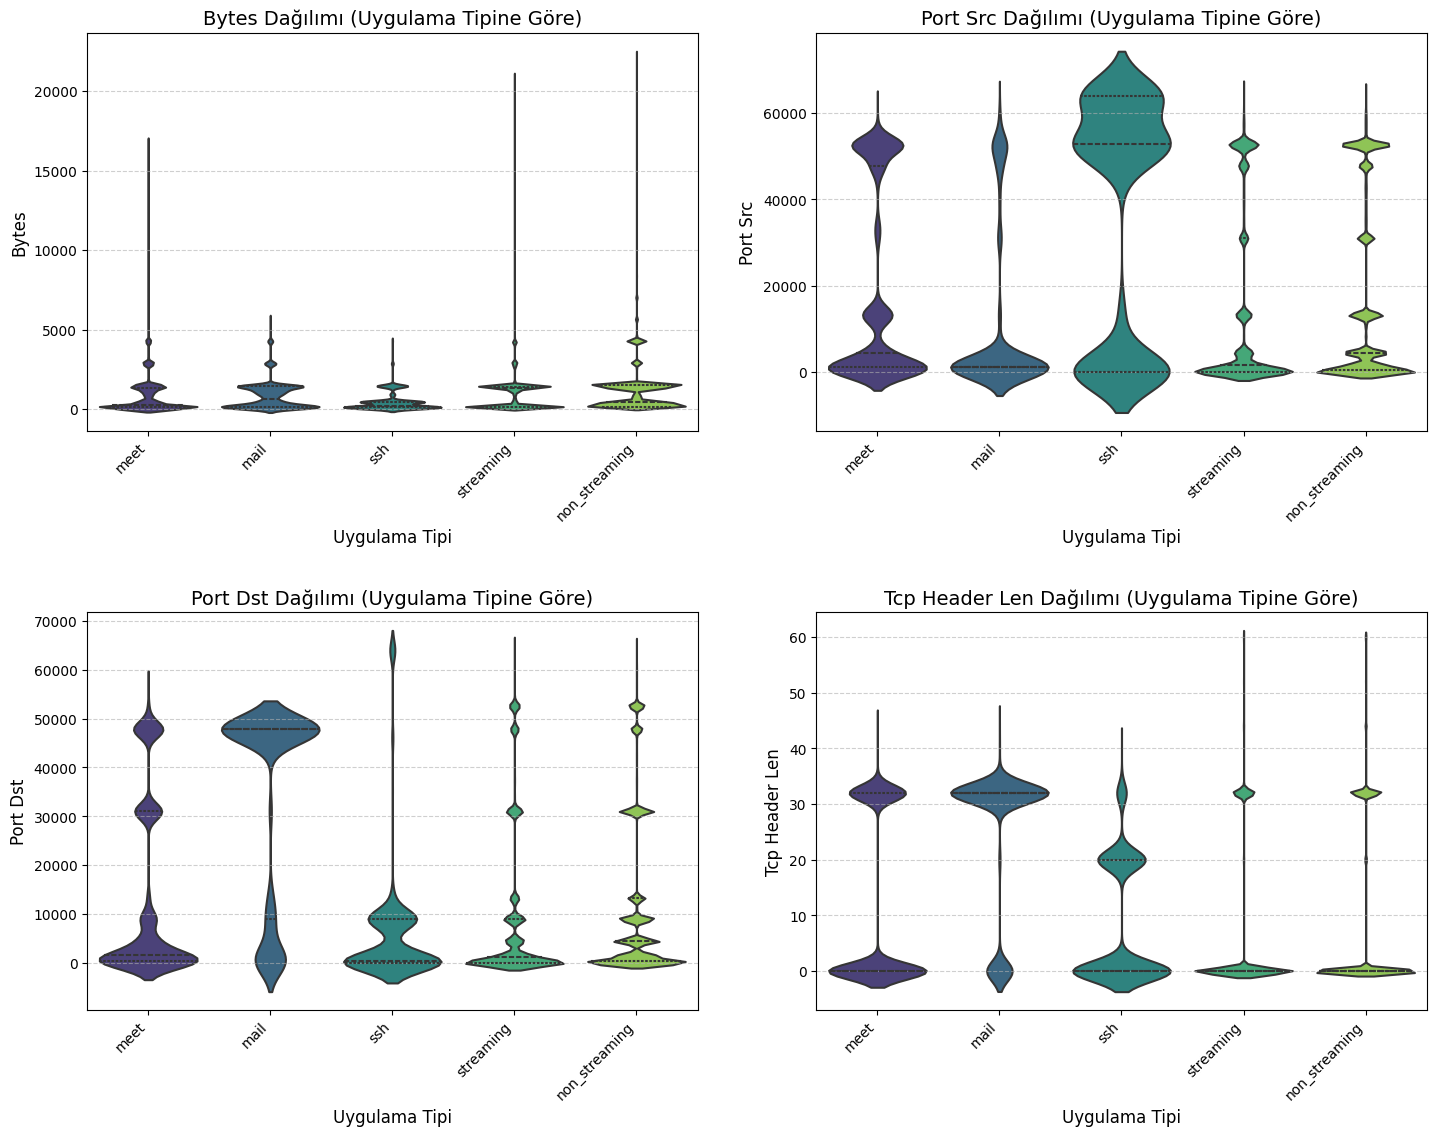

In [6]:
features_to_plot = ['bytes', 'port_src', 'port_dst', 'tcp_header_len']
n_cols = 2
n_rows = (len(features_to_plot) + n_cols - 1) // n_cols

plt.figure(figsize=(15, 6 * n_rows))

for i, feature in enumerate(features_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.violinplot(x='application_type', y=feature, data=df, palette='viridis', inner='quartile', linewidth=1.5)
    plt.title(f'{feature.replace("_", " ").title()} Dağılımı (Uygulama Tipine Göre)', fontsize=14)
    plt.xlabel('Uygulama Tipi', fontsize=12)
    plt.ylabel(feature.replace("_", " ").title(), fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout(pad=3.0)
plt.show()

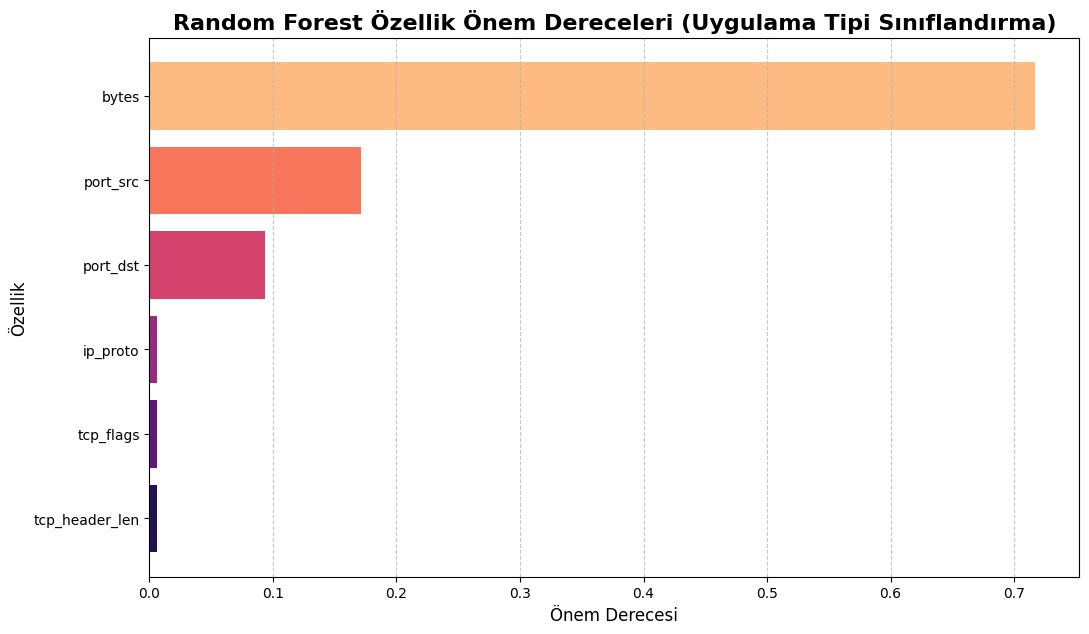

In [7]:
plt.figure(figsize=(12, 7))
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
# Daha görsel ve renkli bir sıralama
feature_importances = feature_importances.sort_values(ascending=True)
colors = sns.color_palette("magma", len(feature_importances))

plt.barh(feature_importances.index, feature_importances.values, color=colors)
plt.title('Random Forest Özellik Önem Dereceleri (Uygulama Tipi Sınıflandırma)', fontsize=16, fontweight='bold')
plt.xlabel('Önem Derecesi', fontsize=12)
plt.ylabel('Özellik', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

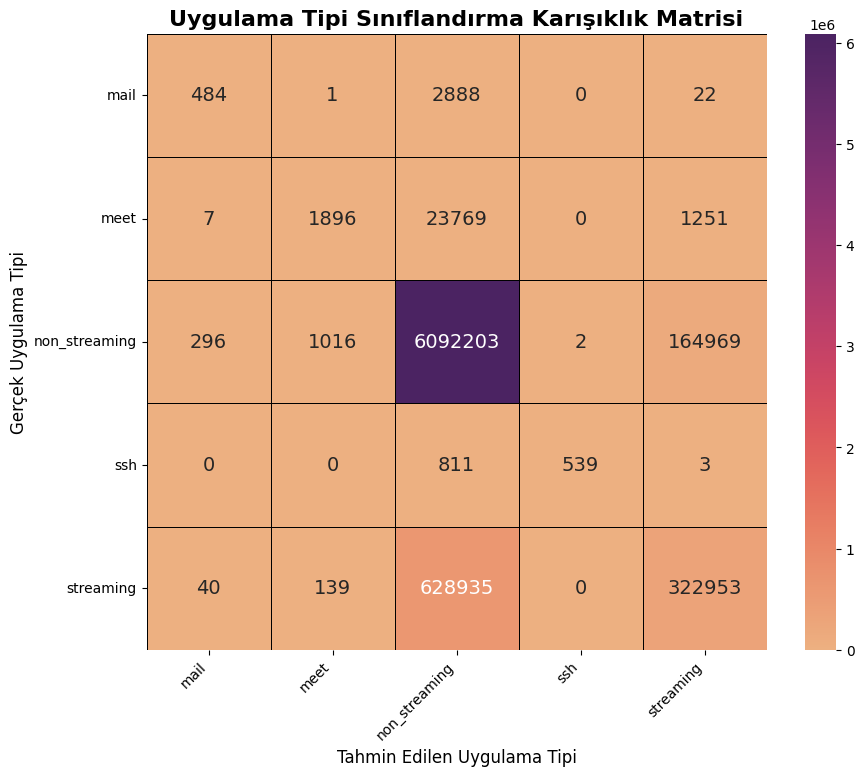

In [8]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='flare', linewidths=.5, linecolor='black',
            xticklabels=le.classes_, yticklabels=le.classes_, annot_kws={"size": 14})
plt.title('Uygulama Tipi Sınıflandırma Karışıklık Matrisi', fontsize=16, fontweight='bold')
plt.xlabel('Tahmin Edilen Uygulama Tipi', fontsize=12)
plt.ylabel('Gerçek Uygulama Tipi', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

In [ ]:
!pip install gradio

Karma Özellik İlişkisi (Pairplot)

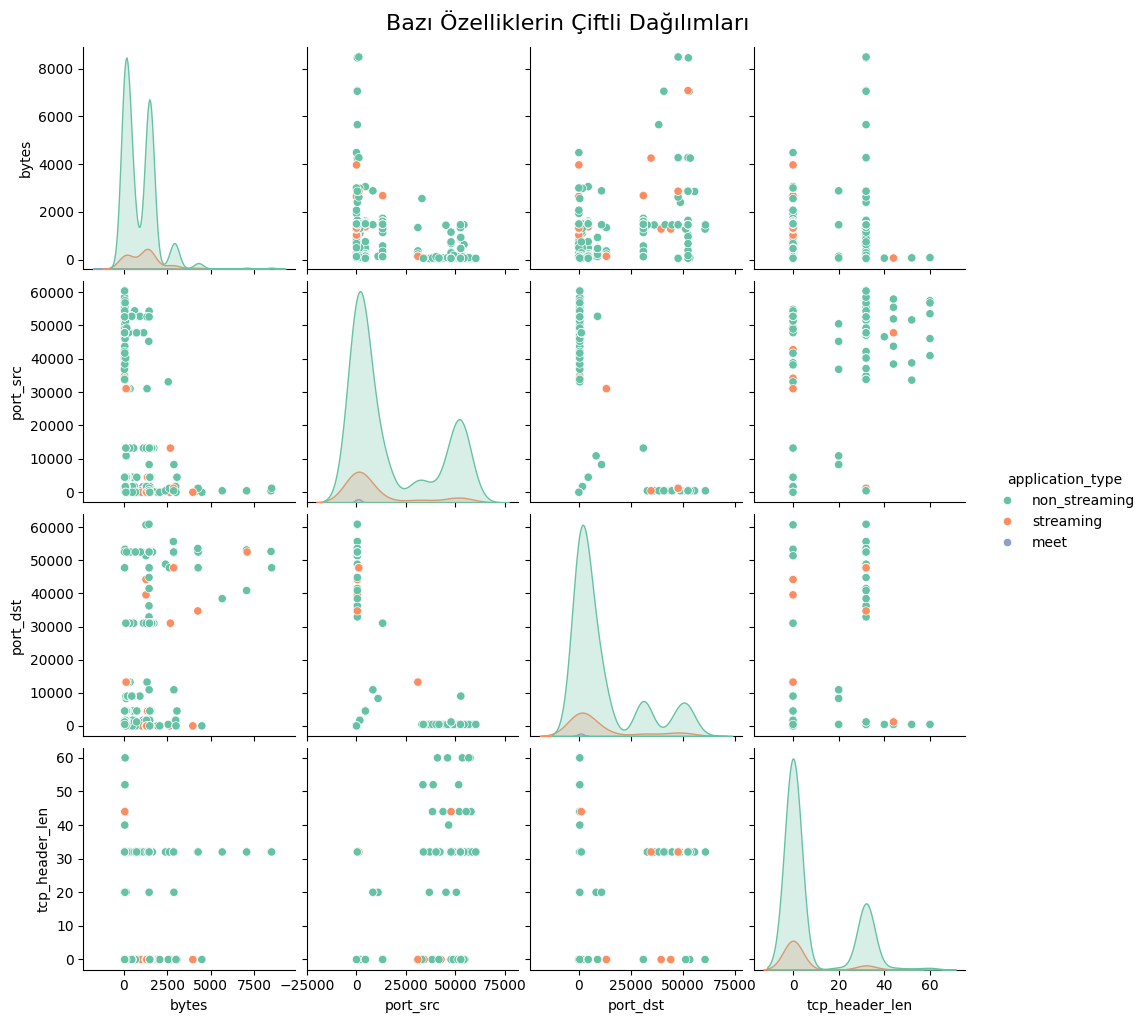

In [10]:
sns.pairplot(df.sample(1000), hue='application_type', vars=['bytes', 'port_src', 'port_dst', 'tcp_header_len'], palette='Set2')
plt.suptitle("Bazı Özelliklerin Çiftli Dağılımları", y=1.02, fontsize=16)
plt.show()


Boxplot ile Uç Değer Analizi

<ipython-input-12-aef34b01b6ec>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='application_type', y='bytes', data=df, palette='Set3')


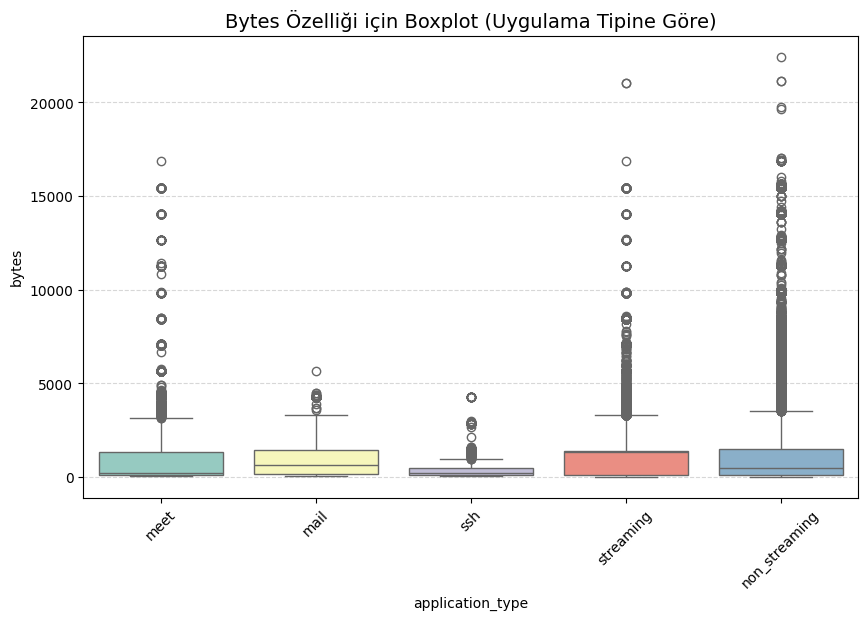

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='application_type', y='bytes', data=df, palette='Set3')
plt.title('Bytes Özelliği için Boxplot (Uygulama Tipine Göre)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


AŞAĞIDA ŞİMDİ HER DOSYADAN

EŞİT ALINARAK İLERLENMİŞTİR

2 OTURUM


In [13]:
base_dataset_path = '/content/drive/MyDrive/my_dataset'
vpn_folders = ['SSTP', 'OpenVPN', 'PPTP', 'L2TP', 'WireGuard', 'L2TP IPsec']
target_file_names = ['meet.json', 'mail.json', 'ssh.json', 'streaming.json','non_streaming.json']

data = []
max_sessions_per_class = 2  # sadece 2 oturum al

# Her VPN protokolü için
for folder in vpn_folders:
    vpn_path = os.path.join(base_dataset_path, 'VPN', folder)
    for file_name in target_file_names:
        path = os.path.join(vpn_path, file_name)
        if not os.path.isfile(path):
            continue

        with open(path) as f:
            try:
                sessions = json.load(f)
                app_type = file_name.replace('.json', '')
                # Sadece 2 oturum al
                sessions = sessions[:max_sessions_per_class]

                for session in sessions:
                    proto = session.get("ip_proto", "").lower()
                    for packet in session.get("x_packets", []):
                        try:
                            data.append({
                                "bytes": int(packet.get("bytes", 0)),
                                "ip_proto": 1 if proto == "tcp" else 0,
                                "port_src": session.get("port_src", -1),
                                "port_dst": session.get("port_dst", -1),
                                "tcp_flags": int(packet.get("tcp_flags", "000000"), 2) if proto == "tcp" else 0,
                                "tcp_header_len": int(packet.get("tcp_header_len", 0)) if proto == "tcp" else 0,
                                "application_type": app_type
                            })
                        except ValueError:
                            continue
            except:
                continue

# Non-VPN tarafı
non_vpn_path = os.path.join(base_dataset_path, 'Non VPN')
for file_name in target_file_names:
    path = os.path.join(non_vpn_path, file_name)
    if not os.path.isfile(path):
        continue

    with open(path) as f:
        try:
            sessions = json.load(f)
            app_type = file_name.replace('.json', '')
            sessions = sessions[:max_sessions_per_class]

            for session in sessions:
                proto = session.get("ip_proto", "").lower()
                for packet in session.get("x_packets", []):
                    try:
                        data.append({
                            "bytes": int(packet.get("bytes", 0)),
                            "ip_proto": 1 if proto == "tcp" else 0,
                            "port_src": session.get("port_src", -1),
                            "port_dst": session.get("port_dst", -1),
                            "tcp_flags": int(packet.get("tcp_flags", "000000"), 2) if proto == "tcp" else 0,
                            "tcp_header_len": int(packet.get("tcp_header_len", 0)) if proto == "tcp" else 0,
                            "application_type": app_type
                        })
                    except ValueError:
                        continue
        except:
            continue

# DataFrame oluştur ve temizle
df = pd.DataFrame(data)
df = df[df['bytes'] >= 0]
df.dropna(inplace=True)

# Bellek optimizasyonu
df['bytes'] = df['bytes'].astype(np.int32)
df['ip_proto'] = df['ip_proto'].astype(np.uint8)
df['port_src'] = df['port_src'].astype(np.int32)
df['port_dst'] = df['port_dst'].astype(np.int32)
df['tcp_flags'] = df['tcp_flags'].astype(np.uint16)
df['tcp_header_len'] = df['tcp_header_len'].astype(np.uint8)

# Label encoding
le = LabelEncoder()
df['application_type_encoded'] = le.fit_transform(df['application_type'])

# Özellik ve hedef ayrımı
X = df[['bytes', 'ip_proto', 'port_src', 'port_dst', 'tcp_flags', 'tcp_header_len']]
y = df['application_type_encoded']

# Ölçekleme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Eğitim/test bölme
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model eğitimi
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Değerlendirme
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Kaydetme
joblib.dump(model, '/content/drive/MyDrive/application_type_classifier_model_small.pkl')
joblib.dump(le, '/content/drive/MyDrive/application_type_label_encoder_small.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/application_type_scaler_small.pkl')
print("Küçük örneklem modeli kaydedildi.")


Accuracy: 0.7329081871893464

Classification Report:
                precision    recall  f1-score   support

         mail       0.47      0.08      0.14       323
         meet       0.75      0.89      0.82     23682
non_streaming       0.69      0.59      0.64      9535
          ssh       0.87      0.77      0.82        99
    streaming       0.71      0.49      0.58      9013

     accuracy                           0.73     42652
    macro avg       0.70      0.56      0.60     42652
 weighted avg       0.73      0.73      0.72     42652


Confusion Matrix:
 [[   26   190    42     0    65]
 [   13 21057  1991    11   610]
 [    2  2721  5650     0  1162]
 [    6    11     4    76     2]
 [    8  4010   544     0  4451]]
Küçük örneklem modeli kaydedildi.


<ipython-input-14-bd9451432234>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='application_type', y=feature, data=df, palette='viridis', inner='quartile', linewidth=1.5)
<ipython-input-14-bd9451432234>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='application_type', y=feature, data=df, palette='viridis', inner='quartile', linewidth=1.5)
<ipython-input-14-bd9451432234>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='application_type', y=feature, data=df, palette='viridis', inner='quartile', linewidth=1.5)
<ipython-inpu

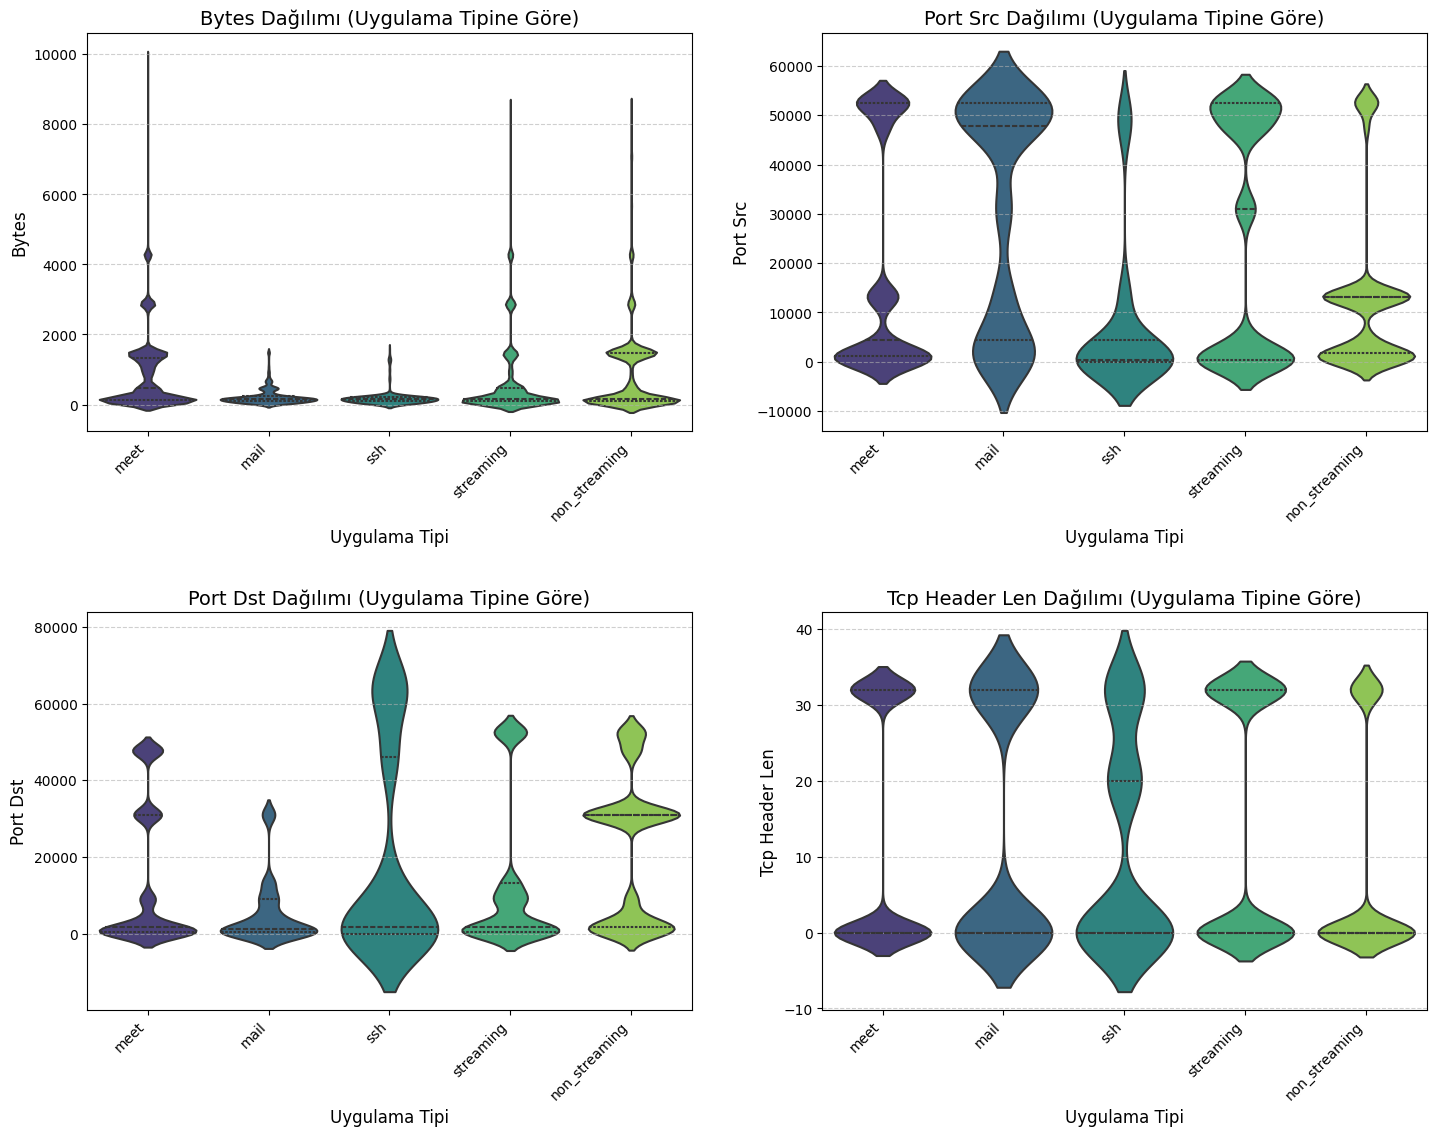

In [14]:
features_to_plot = ['bytes', 'port_src', 'port_dst', 'tcp_header_len']
n_cols = 2
n_rows = (len(features_to_plot) + n_cols - 1) // n_cols

plt.figure(figsize=(15, 6 * n_rows))

for i, feature in enumerate(features_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.violinplot(x='application_type', y=feature, data=df, palette='viridis', inner='quartile', linewidth=1.5)
    plt.title(f'{feature.replace("_", " ").title()} Dağılımı (Uygulama Tipine Göre)', fontsize=14)
    plt.xlabel('Uygulama Tipi', fontsize=12)
    plt.ylabel(feature.replace("_", " ").title(), fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout(pad=3.0)
plt.show()

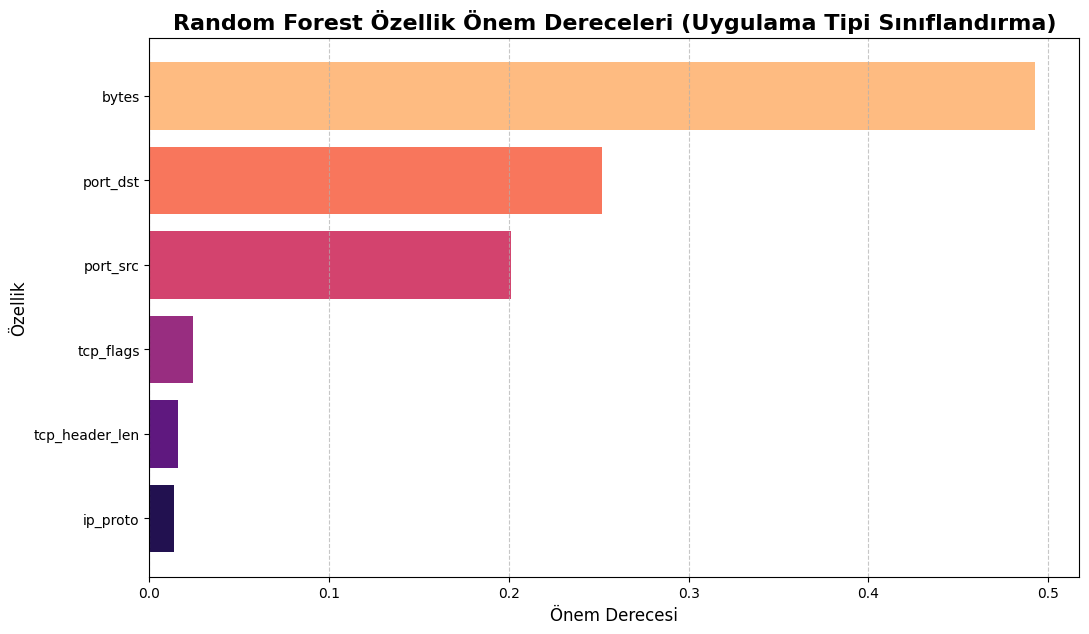

In [18]:
plt.figure(figsize=(12, 7))
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
# Daha görsel ve renkli bir sıralama
feature_importances = feature_importances.sort_values(ascending=True)
colors = sns.color_palette("magma", len(feature_importances))

plt.barh(feature_importances.index, feature_importances.values, color=colors)
plt.title('Random Forest Özellik Önem Dereceleri (Uygulama Tipi Sınıflandırma)', fontsize=16, fontweight='bold')
plt.xlabel('Önem Derecesi', fontsize=12)
plt.ylabel('Özellik', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

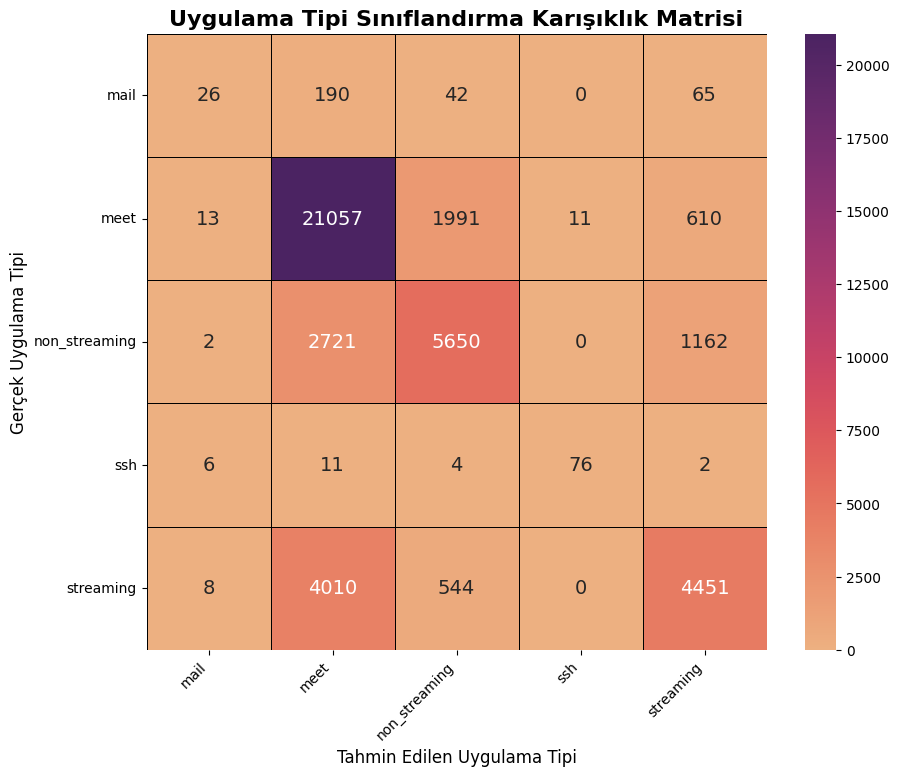

In [17]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='flare', linewidths=.5, linecolor='black',
            xticklabels=le.classes_, yticklabels=le.classes_, annot_kws={"size": 14})
plt.title('Uygulama Tipi Sınıflandırma Karışıklık Matrisi', fontsize=16, fontweight='bold')
plt.xlabel('Tahmin Edilen Uygulama Tipi', fontsize=12)
plt.ylabel('Gerçek Uygulama Tipi', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

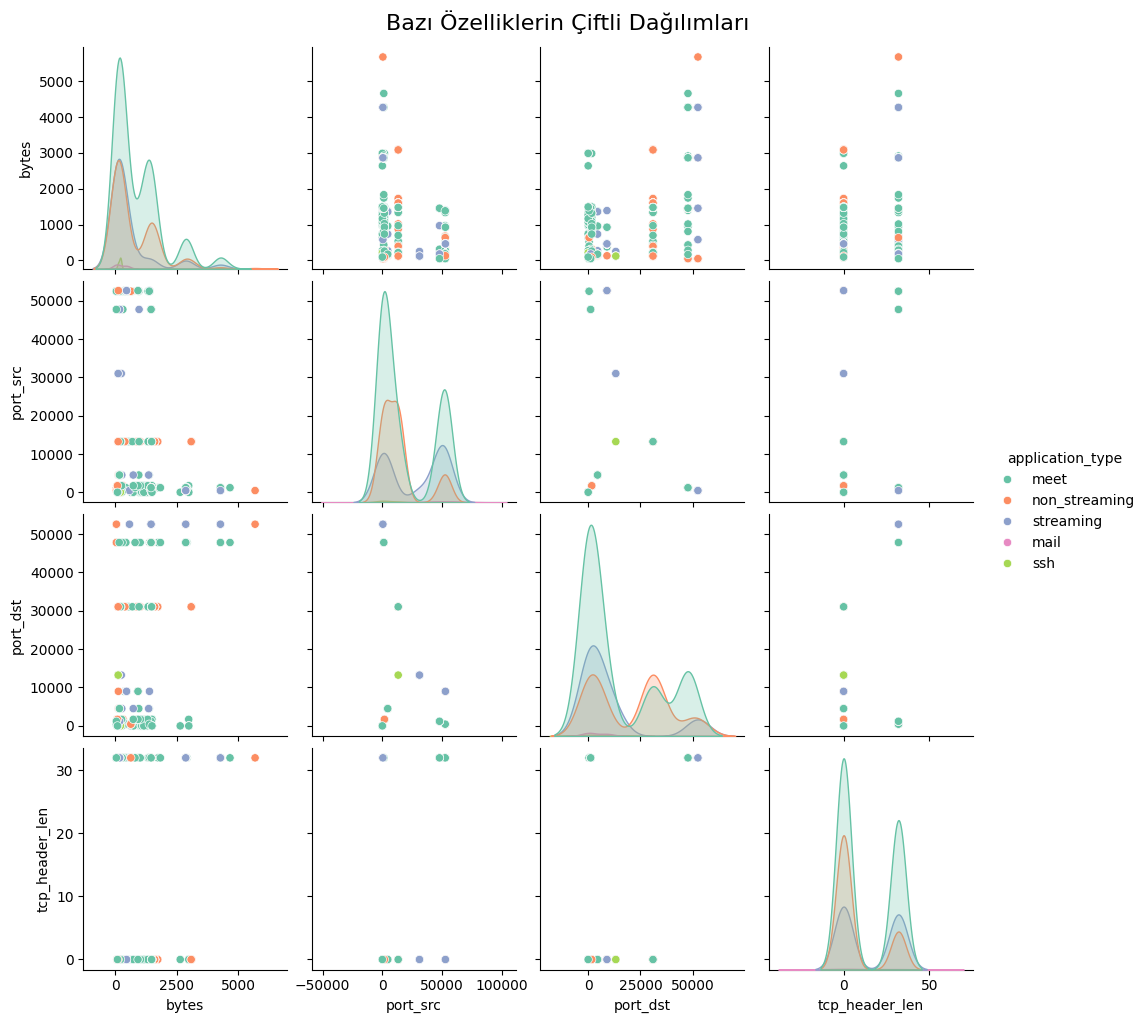

In [16]:
sns.pairplot(df.sample(1000), hue='application_type', vars=['bytes', 'port_src', 'port_dst', 'tcp_header_len'], palette='Set2')
plt.suptitle("Bazı Özelliklerin Çiftli Dağılımları", y=1.02, fontsize=16)
plt.show()


<ipython-input-15-aef34b01b6ec>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='application_type', y='bytes', data=df, palette='Set3')


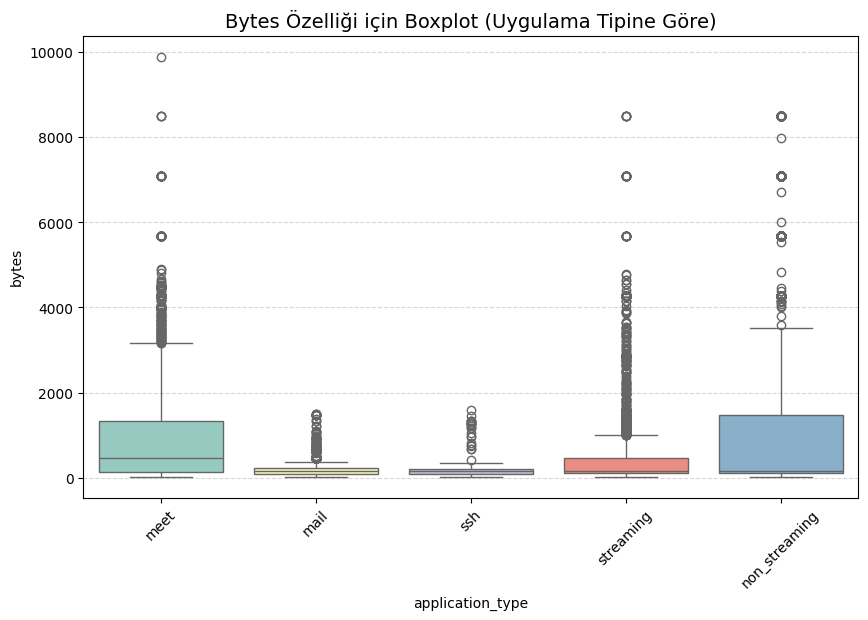

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='application_type', y='bytes', data=df, palette='Set3')
plt.title('Bytes Özelliği için Boxplot (Uygulama Tipine Göre)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
